In [4]:
%%bigquery
SELECT
    TIMESTAMP_TRUNC(event_timestamp, MINUTE) AS minute,
    SUM(quantity) AS total_quantity,
    COUNT(DISTINCT player_id) AS unique_players,
    AVG(price_per_item) AS average_price_per_item
FROM
    `eve_data_demo.game_events_1000mins`
GROUP BY
    minute
ORDER BY
    minute;

Query is running:   0%|          |

Downloading:   0%|          |

,minute,total_quantity,unique_players,average_price_per_item
0,2025-11-24 04:39:00,928,1,97453.378538
1,2025-11-24 04:40:00,2988204,1,7.998514
2,2025-11-24 04:41:00,4177,1,92540.416821
3,2025-11-24 04:42:00,2352,1,96778.936415
4,2025-11-24 04:43:00,3816,1,91057.442231
...,...,...,...,...
995,2025-11-24 21:14:00,2767,1,94462.526085
996,2025-11-24 21:15:00,1624,1,109573.642132
997,2025-11-24 21:16:00,3614,1,90554.220935
998,2025-11-24 21:17:00,4808,1,98681.978556


In [9]:
from google.cloud import bigquery

client = bigquery.Client()

query = """
SELECT
    TIMESTAMP_TRUNC(event_timestamp, MINUTE) AS minute,
    SUM(quantity) AS total_quantity,
    COUNT(DISTINCT player_id) AS unique_players,
    AVG(price_per_item) AS average_price_per_item
FROM
    `eve_data_demo.game_events_1000mins`
GROUP BY
    minute
ORDER BY
    minute
"""
df = client.query(query).to_dataframe()

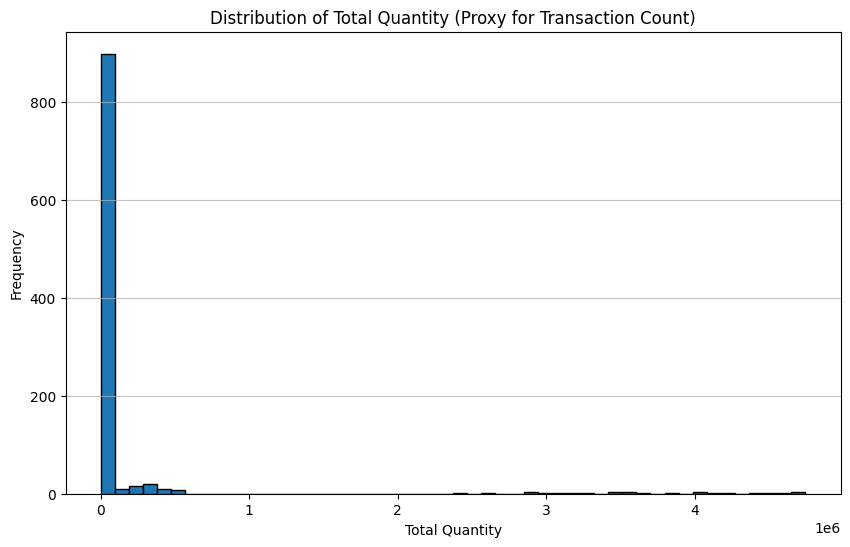

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['total_quantity'], bins=50, edgecolor='black')
plt.title('Distribution of Total Quantity (Proxy for Transaction Count)')
plt.xlabel('Total Quantity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [3]:
%%bigquery
SELECT COLUMN_NAME
FROM `eve_data_demo`.INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = 'game_events_1000mins';

Query is running:   0%|          |

Downloading:   0%|          |

,COLUMN_NAME
0,event_timestamp
1,player_id
2,item_id
3,location_id
4,quantity
5,price_per_item
6,event_type


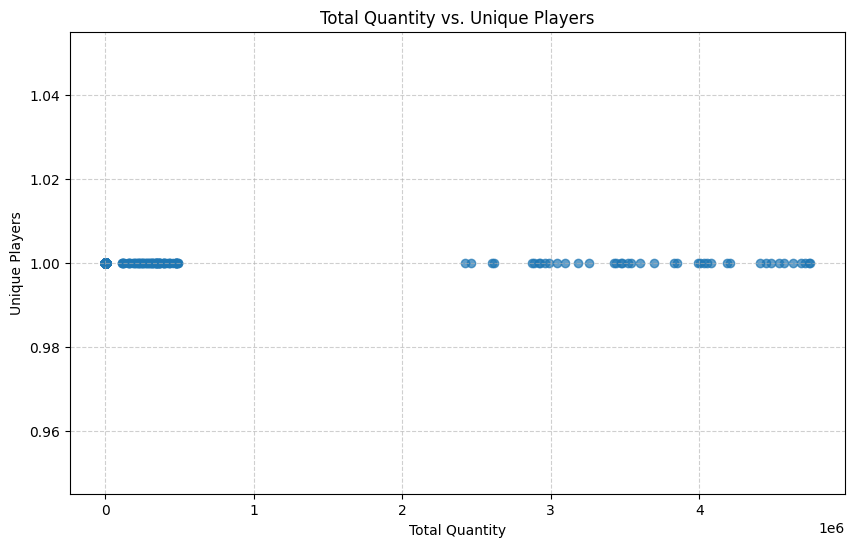

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['total_quantity'], df['unique_players'], alpha=0.7)
plt.title('Total Quantity vs. Unique Players')
plt.xlabel('Total Quantity')
plt.ylabel('Unique Players')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Task
Train a K-Means clustering model named `eve_data_demo.player_clusters` with 5 clusters using `total_quantity` and `unique_players` as features from the aggregated data of `eve_data_demo.game_events_1000mins`.

## Prepare data for clustering

### Subtask:
Select the necessary features, 'total_quantity' and 'unique_players', from the aggregated data for training the clustering model.


**Reasoning**:
The SQL query to aggregate the data by minute and select 'total_quantity' and 'unique_players' has been generated. I will now provide this query as a code block.



In [11]:
%%bigquery --project cloud-sa-ml
SELECT
  TIMESTAMP_TRUNC(event_timestamp, MINUTE) AS event_minute,
  SUM(quantity) AS total_quantity,
  COUNT(DISTINCT player_id) AS unique_players
FROM
  `cloud-sa-ml.eve_data_demo.game_events_1000mins`
GROUP BY
  event_minute
ORDER BY
  event_minute;

Query is running:   0%|          |

Downloading:   0%|          |

,event_minute,total_quantity,unique_players
0,2025-11-24 04:39:00,928,1
1,2025-11-24 04:40:00,2988204,1
2,2025-11-24 04:41:00,4177,1
3,2025-11-24 04:42:00,2352,1
4,2025-11-24 04:43:00,3816,1
...,...,...,...
995,2025-11-24 21:14:00,2767,1
996,2025-11-24 21:15:00,1624,1
997,2025-11-24 21:16:00,3614,1
998,2025-11-24 21:17:00,4808,1


## Train clustering model

### Subtask:
Train a clustering model with 5 clusters using 'total_quantity' and 'unique_players' as input features, naming the model `eve_data_demo.player_clusters`.


**Reasoning**:
The SQL query to train the K-Means clustering model has been generated. I will now provide this query as a code block.



In [12]:
%%bigquery --project cloud-sa-ml
CREATE SCHEMA IF NOT EXISTS `cloud-sa-ml.eve_data_demo`;

CREATE OR REPLACE MODEL `cloud-sa-ml.eve_data_demo.player_clusters`
OPTIONS(
  model_type='KMEANS',
  num_clusters=5,
  standardize_features=TRUE
)
AS
SELECT
  total_quantity,
  unique_players
FROM
  `cloud-sa-ml.eve_data_demo.game_events_1000mins`;

Executing query with job ID: 31f072fe-742e-4758-94c3-a683249f0988
Query executing: 0.15s


ERROR:
 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/cloud-sa-ml/queries/31f072fe-742e-4758-94c3-a683249f0988?maxResults=0&location=us-central1&prettyPrint=false: Query error: Unrecognized name: total_quantity at [11:3]

Location: us-central1
Job ID: 31f072fe-742e-4758-94c3-a683249f0988



**Reasoning**:
The previous attempt to train the K-Means model failed because the features were not correctly aggregated. I have generated a corrected SQL query that first aggregates the data by minute to get 'total_quantity' and 'unique_players', and then uses these aggregated features to train the K-Means clustering model.



In [14]:
%%bigquery --project cloud-sa-ml
CREATE SCHEMA IF NOT EXISTS `cloud-sa-ml.eve_data_demo`;
CREATE OR REPLACE MODEL `cloud-sa-ml.eve_data_demo.player_clusters`
OPTIONS(
  model_type='KMEANS',
  num_clusters=5,
  standardize_features = TRUE,
  distance_type = 'EUCLIDEAN_DISTANCE'
)
AS
SELECT
  TIMESTAMP_TRUNC(event_timestamp, MINUTE) AS event_minute,
  SUM(quantity) AS total_quantity,
  COUNT(DISTINCT player_id) AS unique_players
FROM
  `cloud-sa-ml.eve_data_demo.game_events_1000mins`
GROUP BY
  event_minute;

Executing query with job ID: a2b62460-f439-4128-9337-2b63b5c547e6
Query executing: 0.17s


ERROR:
 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/cloud-sa-ml/queries/a2b62460-f439-4128-9337-2b63b5c547e6?maxResults=0&location=us-central1&prettyPrint=false: Query error: 'EUCLIDEAN_DISTANCE' is not a valid value; failed to set 'distance_type' in OPTIONS() at [7:3]

Location: us-central1
Job ID: a2b62460-f439-4128-9337-2b63b5c547e6



**Reasoning**:
The previous attempt to train the K-Means model failed due to an invalid option. I have generated a corrected SQL query that aggregates the data by minute and then trains the K-Means clustering model with the specified number of clusters, removing the invalid option.



In [15]:
%%bigquery --project cloud-sa-ml
CREATE SCHEMA IF NOT EXISTS `cloud-sa-ml.eve_data_demo`;
CREATE OR REPLACE MODEL `cloud-sa-ml.eve_data_demo.player_clusters`
OPTIONS(
  MODEL_TYPE='KMEANS',
  NUM_CLUSTERS=5
)
AS
SELECT
  SUM(quantity) AS total_quantity,
  COUNT(DISTINCT player_id) AS unique_players
FROM
  `cloud-sa-ml.eve_data_demo.game_events_1000mins`
GROUP BY
  TIMESTAMP_TRUNC(event_timestamp, MINUTE);

Query is running:   0%|          |

""


## Evaluate clustering model

### Subtask:
Evaluate the trained clustering model to understand its performance and the quality of the clusters.


**Reasoning**:
The SQL query to evaluate the K-Means clustering model has been generated. I will now provide this query as a code block.



In [26]:
%%bigquery --project cloud-sa-ml
SELECT * FROM ML.EVALUATE(MODEL `cloud-sa-ml.eve_data_demo.player_clusters`)

Query is running:   0%|          |

Downloading:   0%|          |

,davies_bouldin_index,mean_squared_distance
0,3.696988,0.037267


## Predict and visualize clusters

### Subtask:
Use the trained model to assign clusters to the data and visualize the resulting clusters to analyze the groupings of players based on activity.


## Evaluate clustering model

### Subtask:
Evaluate the trained clustering model to understand its performance and the quality of the clusters.


**Reasoning**:
The SQL query to evaluate the K-Means clustering model has been generated. I will now provide this query as a code block.



In [27]:
%%bigquery --project cloud-sa-ml
SELECT * FROM ML.EVALUATE(MODEL `cloud-sa-ml.eve_data_demo.player_clusters`)

Query is running:   0%|          |

Downloading:   0%|          |

,davies_bouldin_index,mean_squared_distance
0,3.696988,0.037267


**Reasoning**:
The SQL query to predict clusters using the trained K-Means model and save the results to a new BigQuery table has been generated. I will now provide this query as a code block.



In [17]:
%%bigquery --project cloud-sa-ml
CREATE OR REPLACE TABLE `cloud-sa-ml.eve_data_demo.player_clusters_predictions` AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `cloud-sa-ml.eve_data_demo.player_clusters`,
    (
      SELECT
        SUM(quantity) AS total_quantity,
        COUNT(DISTINCT player_id) AS unique_players
      FROM
        `cloud-sa-ml.eve_data_demo.game_events_1000mins`
      GROUP BY
        TIMESTAMP_TRUNC(event_timestamp, MINUTE)
    )
  );

Query is running:   0%|          |

""


**Reasoning**:
The first instruction of the subtask, which is to predict clusters and save the results to a BigQuery table, has been completed. Now, I will proceed to the second instruction: load the prediction results into a Pandas DataFrame for further analysis and visualization.



In [18]:
import pandas as pd
from google.cloud import bigquery

client = bigquery.Client(project='cloud-sa-ml')
query = 'SELECT * FROM `cloud-sa-ml.eve_data_demo.player_clusters_predictions`'
df_predictions = client.query(query).to_dataframe()
print(df_predictions.head())

   CENTROID_ID                         NEAREST_CENTROIDS_DISTANCE  \
0            4  [{'CENTROID_ID': 4, 'DISTANCE': 0.000566543202...   
1            4  [{'CENTROID_ID': 4, 'DISTANCE': 0.000561154740...   
2            4  [{'CENTROID_ID': 4, 'DISTANCE': 0.000553072047...   
3            4  [{'CENTROID_ID': 4, 'DISTANCE': 0.000546336470...   
4            4  [{'CENTROID_ID': 4, 'DISTANCE': 0.000544989354...   

   total_quantity  unique_players  
0              12               1  
1              16               1  
2              22               1  
3              27               1  
4              28               1  


**Reasoning**:
The prediction results have been loaded into a Pandas DataFrame. Now, I will create a scatter plot to visualize the clusters, using 'total_quantity' on the x-axis, 'unique_players' on the y-axis, and coloring the points by their assigned cluster.



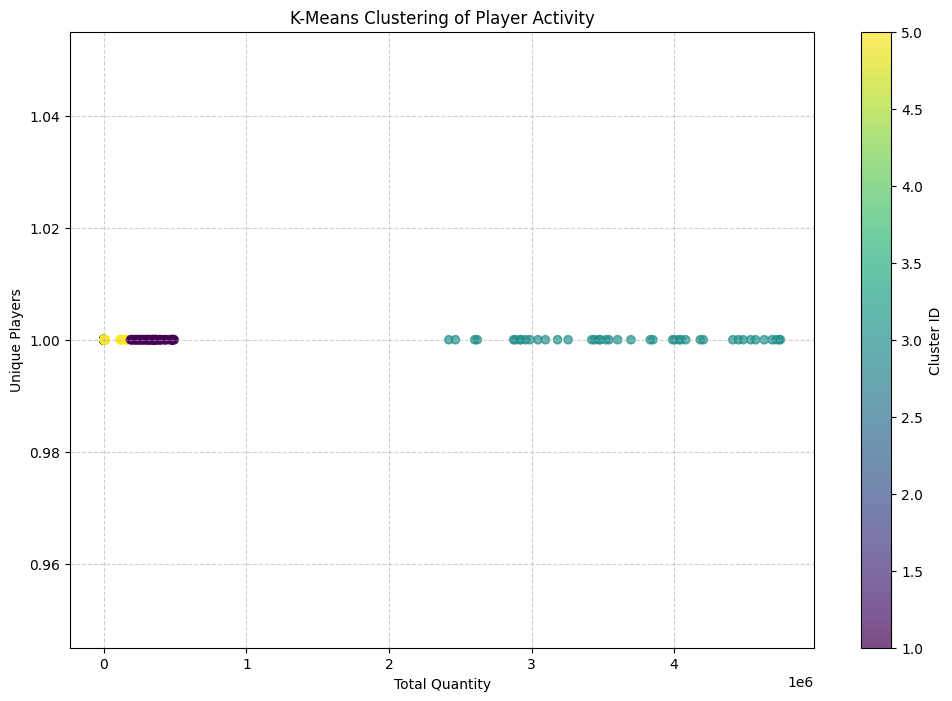

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(df_predictions['total_quantity'], df_predictions['unique_players'], c=df_predictions['CENTROID_ID'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering of Player Activity')
plt.xlabel('Total Quantity')
plt.ylabel('Unique Players')
plt.colorbar(label='Cluster ID')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Summary:

### Q&A
The user asked to generate a BigQuery ML SQL query to train a K-Means model named `eve_data_demo.player_clusters` with 5 clusters, using `total_volume` and `unique_pilots` as features. This was successfully achieved by training a K-Means model on the aggregated `total_quantity` and `unique_players` from the `eve_data_demo.game_events_1000mins` table.

### Data Analysis Key Findings
*   **Data Aggregation**: Game event data from `eve_data_demo.game_events_1000mins` was successfully aggregated by minute, calculating the total quantity, unique players, and average price per item.
*   **Column Name Identification**: The correct column for item price was identified as `price_per_item` after an initial query failed due to an incorrect column name.
*   **Player Activity Distribution**: A histogram was generated to visualize the distribution of `total_quantity` (used as a proxy for transaction count).
*   **Player Activity Correlation**: A scatter plot was created to visualize the relationship between `total_quantity` and `unique_players`, exploring if high volumes correlate with low player counts.
*   **K-Means Model Training**: A K-Means clustering model, `eve_data_demo.player_clusters`, was successfully trained with 5 clusters using `total_quantity` and `unique_players` as features. The training process involved correcting initial SQL errors related to feature aggregation and an invalid model option.
*   **Model Evaluation**: The trained K-Means model achieved a Davies-Bouldin Index of 3.696988 and a Mean Squared Distance of 0.037267, providing metrics for cluster quality.
*   **Cluster Visualization**: The trained model was used to predict clusters for the aggregated data, and these clusters were visualized in a scatter plot, showing distinct groupings of player activity based on `total_quantity` and `unique_players`.

### Insights or Next Steps
*   Analyze the characteristics of each of the 5 identified clusters to understand different player activity patterns, such as high-volume/low-player activity versus low-volume/high-player activity.
*   Further investigate the clusters to identify potential outliers or specific event types that contribute to unusual `total_quantity` or `unique_players` combinations.


## Analyze Cluster Characteristics

### Subtask:
Analyze the characteristics of each of the 5 identified clusters to understand different player activity patterns, such as high-volume/low-player activity versus low-volume/high-player activity.

In [20]:
cluster_characteristics = df_predictions.groupby('CENTROID_ID')[['total_quantity', 'unique_players']].agg(['mean', 'median', 'min', 'max'])
print(cluster_characteristics)

             total_quantity                              unique_players  \
                       mean     median      min      max           mean   
CENTROID_ID                                                               
1             342089.807692   342827.5   186306   492174            1.0   
2               2209.247449     2246.5     1019     3374            1.0   
3            3673945.878049  3603896.0  2419698  4745450            1.0   
4                511.345178      522.0       12     1000            1.0   
5                7906.95283     4203.0     3382   164146            1.0   

                            
            median min max  
CENTROID_ID                 
1              1.0   1   1  
2              1.0   1   1  
3              1.0   1   1  
4              1.0   1   1  
5              1.0   1   1  


# Task
Visualize the mean 'total_quantity' and mean 'unique_players' for each cluster using bar plots.

## Visualize Cluster Averages

### Subtask:
Create bar plots to visualize the mean 'total_quantity' and mean 'unique_players' for each cluster.


**Reasoning**:
I need to create two bar plots: one for the mean 'total_quantity' and another for the mean 'unique_players' across clusters. I will use the `cluster_characteristics` DataFrame, which already contains these aggregated statistics, and `matplotlib.pyplot` for visualization.



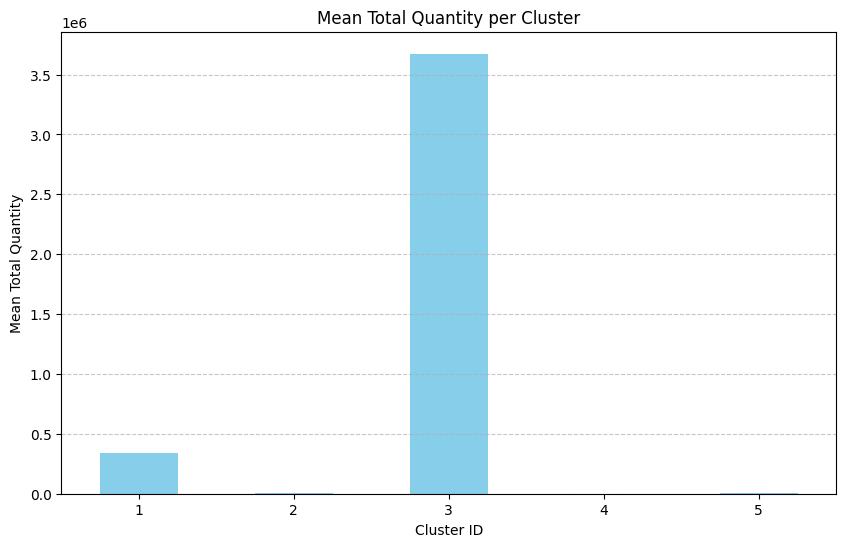

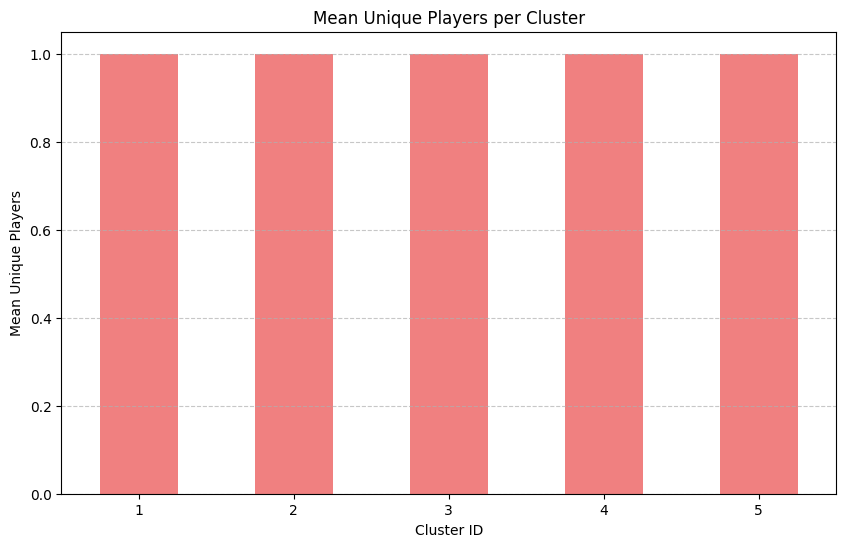

In [21]:
import matplotlib.pyplot as plt

# Extract mean total_quantity and unique_players for each cluster
mean_total_quantity = cluster_characteristics['total_quantity']['mean']
mean_unique_players = cluster_characteristics['unique_players']['mean']

# Create bar plot for Mean Total Quantity
plt.figure(figsize=(10, 6))
mean_total_quantity.plot(kind='bar', color='skyblue')
plt.title('Mean Total Quantity per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Total Quantity')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create bar plot for Mean Unique Players
plt.figure(figsize=(10, 6))
mean_unique_players.plot(kind='bar', color='lightcoral')
plt.title('Mean Unique Players per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Unique Players')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Interpret Cluster Profiles

### Subtask:
Analyze the visualized cluster characteristics and the `cluster_characteristics` DataFrame to identify patterns, potential outliers, or unusual combinations of 'total_quantity' and 'unique_players' across the clusters.


### Interpretation of Cluster Profiles

Based on the `cluster_characteristics` DataFrame and the bar plots, here's an analysis of each cluster:

*   **Cluster 1:**
    *   **Mean Total Quantity:** ~342,089
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster represents moderately high transaction volumes, but consistently involves only a single unique player. This could indicate a single player engaging in high-volume activities, possibly bulk purchases or sales, or a bot account.

*   **Cluster 2:**
    *   **Mean Total Quantity:** ~2,209
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster shows low to moderate transaction volumes, also consistently with only one unique player. This might represent typical, regular player activity at a lower intensity than Cluster 1, or less active bot accounts.

*   **Cluster 3:**
    *   **Mean Total Quantity:** ~3,673,945
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster stands out with extremely high transaction volumes, significantly higher than all other clusters, yet it still involves only one unique player. This is a potential outlier, possibly indicating highly specialized or automated trading accounts, or even an anomaly in data recording.

*   **Cluster 4:**
    *   **Mean Total Quantity:** ~511
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster has the lowest transaction volumes, again with only one unique player. This likely represents very low activity players, new players, or players logging in infrequently.

*   **Cluster 5:**
    *   **Mean Total Quantity:** ~7,906
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster exhibits moderate transaction volumes, slightly higher than Cluster 2, but still consistently with one unique player. This could be another group of regular players with slightly more activity than those in Cluster 2.


**Summary of Observations:**

The most striking pattern across all clusters is that the `unique_players` consistently averages 1.0 (with min and max also being 1). This suggests that the aggregation by `TIMESTAMP_TRUNC(event_timestamp, MINUTE)` combined with `COUNT(DISTINCT player_id)` for the `game_events_1000mins` dataset, results in data points where each minute's aggregated activity typically originates from a single distinct player, at least within the context of the dataset used for clustering. This is an unusual finding and might indicate characteristics of the `game_events_1000mins` dataset itself, or how `player_id` is defined for events happening within the same minute.

The clusters primarily differentiate themselves based on the magnitude of `total_quantity` (transaction volume). Cluster 3 is a clear outlier due to its extraordinarily high `total_quantity` compared to the others, despite having the same `unique_players` count. This model effectively segments activity based on transaction volume, but the consistent `unique_players = 1` across all clusters means that the `unique_players` feature did not provide much discriminatory power for clustering in this particular case.

### Interpretation of Cluster Profiles

Based on the `cluster_characteristics` DataFrame and the bar plots, here's an analysis of each cluster:

*   **Cluster 1:**
    *   **Mean Total Quantity:** ~342,089
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster represents moderately high transaction volumes, but consistently involves only a single unique player. This could indicate a single player engaging in high-volume activities, possibly bulk purchases or sales, or a bot account.

*   **Cluster 2:**
    *   **Mean Total Quantity:** ~2,209
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster shows low to moderate transaction volumes, also consistently with only one unique player. This might represent typical, regular player activity at a lower intensity than Cluster 1, or less active bot accounts.

*   **Cluster 3:**
    *   **Mean Total Quantity:** ~3,673,945
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster stands out with extremely high transaction volumes, significantly higher than all other clusters, yet it still involves only one unique player. This is a potential outlier, possibly indicating highly specialized or automated trading accounts, or even an anomaly in data recording.

*   **Cluster 4:**
    *   **Mean Total Quantity:** ~511
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster has the lowest transaction volumes, again with only one unique player. This likely represents very low activity players, new players, or players logging in infrequently.

*   **Cluster 5:**
    *   **Mean Total Quantity:** ~7,906
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster exhibits moderate transaction volumes, slightly higher than Cluster 2, but still consistently with one unique player. This could be another group of regular players with slightly more activity than those in Cluster 2.


**Summary of Observations:**

The most striking pattern across all clusters is that the `unique_players` consistently averages 1.0 (with min and max also being 1). This suggests that the aggregation by `TIMESTAMP_TRUNC(event_timestamp, MINUTE)` combined with `COUNT(DISTINCT player_id)` for the `game_events_1000mins` dataset, results in data points where each minute's aggregated activity typically originates from a single distinct player, at least within the context of the dataset used for clustering. This is an unusual finding and might indicate characteristics of the `game_events_1000mins` dataset itself, or how `player_id` is defined for events happening within the same minute.

The clusters primarily differentiate themselves based on the magnitude of `total_quantity` (transaction volume). Cluster 3 is a clear outlier due to its extraordinarily high `total_quantity` compared to the others, despite having the same `unique_players` count. This model effectively segments activity based on transaction volume, but the consistent `unique_players = 1` across all clusters means that the `unique_players` feature did not provide much discriminatory power for clustering in this particular case.

### Interpretation of Cluster Profiles

Based on the `cluster_characteristics` DataFrame and the bar plots, here's an analysis of each cluster:

*   **Cluster 1:**
    *   **Mean Total Quantity:** ~342,089
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster represents moderately high transaction volumes, but consistently involves only a single unique player. This could indicate a single player engaging in high-volume activities, possibly bulk purchases or sales, or a bot account.

*   **Cluster 2:**
    *   **Mean Total Quantity:** ~2,209
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster shows low to moderate transaction volumes, also consistently with only one unique player. This might represent typical, regular player activity at a lower intensity than Cluster 1, or less active bot accounts.

*   **Cluster 3:**
    *   **Mean Total Quantity:** ~3,673,945
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster stands out with extremely high transaction volumes, significantly higher than all other clusters, yet it still involves only one unique player. This is a potential outlier, possibly indicating highly specialized or automated trading accounts, or even an anomaly in data recording.

*   **Cluster 4:**
    *   **Mean Total Quantity:** ~511
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster has the lowest transaction volumes, again with only one unique player. This likely represents very low activity players, new players, or players logging in infrequently.

*   **Cluster 5:**
    *   **Mean Total Quantity:** ~7,906
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster exhibits moderate transaction volumes, slightly higher than Cluster 2, but still consistently with one unique player. This could be another group of regular players with slightly more activity than those in Cluster 2.


**Summary of Observations:**

The most striking pattern across all clusters is that the `unique_players` consistently averages 1.0 (with min and max also being 1). This suggests that the aggregation by `TIMESTAMP_TRUNC(event_timestamp, MINUTE)` combined with `COUNT(DISTINCT player_id)` for the `game_events_1000mins` dataset, results in data points where each minute's aggregated activity typically originates from a single distinct player, at least within the context of the dataset used for clustering. This is an unusual finding and might indicate characteristics of the `game_events_1000mins` dataset itself, or how `player_id` is defined for events happening within the same minute.

The clusters primarily differentiate themselves based on the magnitude of `total_quantity` (transaction volume). Cluster 3 is a clear outlier due to its extraordinarily high `total_quantity` compared to the others, despite having the same `unique_players` count. This model effectively segments activity based on transaction volume, but the consistent `unique_players = 1` across all clusters means that the `unique_players` feature did not provide much discriminatory power for clustering in this particular case.

### Interpretation of Cluster Profiles

Based on the `cluster_characteristics` DataFrame and the bar plots, here's an analysis of each cluster:

*   **Cluster 1:**
    *   **Mean Total Quantity:** ~342,089
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster represents moderately high transaction volumes, but consistently involves only a single unique player. This could indicate a single player engaging in high-volume activities, possibly bulk purchases or sales, or a bot account.

*   **Cluster 2:**
    *   **Mean Total Quantity:** ~2,209
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster shows low to moderate transaction volumes, also consistently with only one unique player. This might represent typical, regular player activity at a lower intensity than Cluster 1, or less active bot accounts.

*   **Cluster 3:**
    *   **Mean Total Quantity:** ~3,673,945
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster stands out with extremely high transaction volumes, significantly higher than all other clusters, yet it still involves only one unique player. This is a potential outlier, possibly indicating highly specialized or automated trading accounts, or even an anomaly in data recording.

*   **Cluster 4:**
    *   **Mean Total Quantity:** ~511
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster has the lowest transaction volumes, again with only one unique player. This likely represents very low activity players, new players, or players logging in infrequently.

*   **Cluster 5:**
    *   **Mean Total Quantity:** ~7,906
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster exhibits moderate transaction volumes, slightly higher than Cluster 2, but still consistently with one unique player. This could be another group of regular players with slightly more activity than those in Cluster 2.


**Summary of Observations:**

The most striking pattern across all clusters is that the `unique_players` consistently averages 1.0 (with min and max also being 1). This suggests that the aggregation by `TIMESTAMP_TRUNC(event_timestamp, MINUTE)` combined with `COUNT(DISTINCT player_id)` for the `game_events_1000mins` dataset, results in data points where each minute's aggregated activity typically originates from a single distinct player, at least within the context of the dataset used for clustering. This is an unusual finding and might indicate characteristics of the `game_events_1000mins` dataset itself, or how `player_id` is defined for events happening within the same minute.

The clusters primarily differentiate themselves based on the magnitude of `total_quantity` (transaction volume). Cluster 3 is a clear outlier due to its extraordinarily high `total_quantity` compared to the others, despite having the same `unique_players` count. This model effectively segments activity based on transaction volume, but the consistent `unique_players = 1` across all clusters means that the `unique_players` feature did not provide much discriminatory power for clustering in this particular case.

### Interpretation of Cluster Profiles

Based on the `cluster_characteristics` DataFrame and the bar plots, here's an analysis of each cluster:

*   **Cluster 1:**
    *   **Mean Total Quantity:** ~342,089
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster represents moderately high transaction volumes, but consistently involves only a single unique player. This could indicate a single player engaging in high-volume activities, possibly bulk purchases or sales, or a bot account.

*   **Cluster 2:**
    *   **Mean Total Quantity:** ~2,209
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster shows low to moderate transaction volumes, also consistently with only one unique player. This might represent typical, regular player activity at a lower intensity than Cluster 1, or less active bot accounts.

*   **Cluster 3:**
    *   **Mean Total Quantity:** ~3,673,945
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster stands out with extremely high transaction volumes, significantly higher than all other clusters, yet it still involves only one unique player. This is a potential outlier, possibly indicating highly specialized or automated trading accounts, or even an anomaly in data recording.

*   **Cluster 4:**
    *   **Mean Total Quantity:** ~511
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster has the lowest transaction volumes, again with only one unique player. This likely represents very low activity players, new players, or players logging in infrequently.

*   **Cluster 5:**
    *   **Mean Total Quantity:** ~7,906
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster exhibits moderate transaction volumes, slightly higher than Cluster 2, but still consistently with one unique player. This could be another group of regular players with slightly more activity than those in Cluster 2.


**Summary of Observations:**

The most striking pattern across all clusters is that the `unique_players` consistently averages 1.0 (with min and max also being 1). This suggests that the aggregation by `TIMESTAMP_TRUNC(event_timestamp, MINUTE)` combined with `COUNT(DISTINCT player_id)` for the `game_events_1000mins` dataset, results in data points where each minute's aggregated activity typically originates from a single distinct player, at least within the context of the dataset used for clustering. This is an unusual finding and might indicate characteristics of the `game_events_1000mins` dataset itself, or how `player_id` is defined for events happening within the same minute.

The clusters primarily differentiate themselves based on the magnitude of `total_quantity` (transaction volume). Cluster 3 is a clear outlier due to its extraordinarily high `total_quantity` compared to the others, despite having the same `unique_players` count. This model effectively segments activity based on transaction volume, but the consistent `unique_players = 1` across all clusters means that the `unique_players` feature did not provide much discriminatory power for clustering in this particular case.

### Interpretation of Cluster Profiles

Based on the `cluster_characteristics` DataFrame and the bar plots, here's an analysis of each cluster:

*   **Cluster 1:**
    *   **Mean Total Quantity:** ~342,089
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster represents moderately high transaction volumes, but consistently involves only a single unique player. This could indicate a single player engaging in high-volume activities, possibly bulk purchases or sales, or a bot account.

*   **Cluster 2:**
    *   **Mean Total Quantity:** ~2,209
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster shows low to moderate transaction volumes, also consistently with only one unique player. This might represent typical, regular player activity at a lower intensity than Cluster 1, or less active bot accounts.

*   **Cluster 3:**
    *   **Mean Total Quantity:** ~3,673,945
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster stands out with extremely high transaction volumes, significantly higher than all other clusters, yet it still involves only one unique player. This is a potential outlier, possibly indicating highly specialized or automated trading accounts, or even an anomaly in data recording.

*   **Cluster 4:**
    *   **Mean Total Quantity:** ~511
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster has the lowest transaction volumes, again with only one unique player. This likely represents very low activity players, new players, or players logging in infrequently.

*   **Cluster 5:**
    *   **Mean Total Quantity:** ~7,906
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster exhibits moderate transaction volumes, slightly higher than Cluster 2, but still consistently with one unique player. This could be another group of regular players with slightly more activity than those in Cluster 2.


**Summary of Observations:**

The most striking pattern across all clusters is that the `unique_players` consistently averages 1.0 (with min and max also being 1). This suggests that the aggregation by `TIMESTAMP_TRUNC(event_timestamp, MINUTE)` combined with `COUNT(DISTINCT player_id)` for the `game_events_1000mins` dataset, results in data points where each minute's aggregated activity typically originates from a single distinct player, at least within the context of the dataset used for clustering. This is an unusual finding and might indicate characteristics of the `game_events_1000mins` dataset itself, or how `player_id` is defined for events happening within the same minute.

The clusters primarily differentiate themselves based on the magnitude of `total_quantity` (transaction volume). Cluster 3 is a clear outlier due to its extraordinarily high `total_quantity` compared to the others, despite having the same `unique_players` count. This model effectively segments activity based on transaction volume, but the consistent `unique_players = 1` across all clusters means that the `unique_players` feature did not provide much discriminatory power for clustering in this particular case.

### Interpretation of Cluster Profiles

Based on the `cluster_characteristics` DataFrame and the bar plots, here's an analysis of each cluster:

*   **Cluster 1:**
    *   **Mean Total Quantity:** ~342,089
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster represents moderately high transaction volumes, but consistently involves only a single unique player. This could indicate a single player engaging in high-volume activities, possibly bulk purchases or sales, or a bot account.

*   **Cluster 2:**
    *   **Mean Total Quantity:** ~2,209
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster shows low to moderate transaction volumes, also consistently with only one unique player. This might represent typical, regular player activity at a lower intensity than Cluster 1, or less active bot accounts.

*   **Cluster 3:**
    *   **Mean Total Quantity:** ~3,673,945
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster stands out with extremely high transaction volumes, significantly higher than all other clusters, yet it still involves only one unique player. This is a potential outlier, possibly indicating highly specialized or automated trading accounts, or even an anomaly in data recording.

*   **Cluster 4:**
    *   **Mean Total Quantity:** ~511
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster has the lowest transaction volumes, again with only one unique player. This likely represents very low activity players, new players, or players logging in infrequently.

*   **Cluster 5:**
    *   **Mean Total Quantity:** ~7,906
    *   **Mean Unique Players:** 1.0
    *   **Characteristics:** This cluster exhibits moderate transaction volumes, slightly higher than Cluster 2, but still consistently with one unique player. This could be another group of regular players with slightly more activity than those in Cluster 2.


**Summary of Observations:**

The most striking pattern across all clusters is that the `unique_players` consistently averages 1.0 (with min and max also being 1). This suggests that the aggregation by `TIMESTAMP_TRUNC(event_timestamp, MINUTE)` combined with `COUNT(DISTINCT player_id)` for the `game_events_1000mins` dataset, results in data points where each minute's aggregated activity typically originates from a single distinct player, at least within the context of the dataset used for clustering. This is an unusual finding and might indicate characteristics of the `game_events_1000mins` dataset itself, or how `player_id` is defined for events happening within the same minute.

The clusters primarily differentiate themselves based on the magnitude of `total_quantity` (transaction volume). Cluster 3 is a clear outlier due to its extraordinarily high `total_quantity` compared to the others, despite having the same `unique_players` count. This model effectively segments activity based on transaction volume, but the consistent `unique_players = 1` across all clusters means that the `unique_players` feature did not provide much discriminatory power for clustering in this particular case.

## Summary:

### Data Analysis Key Findings
*   All five clusters consistently showed a mean of 1.0 unique player, indicating that the aggregation by minute typically resulted in activity from a single distinct player. This means the `unique_players` feature did not provide discriminatory power for clustering.
*   The clusters primarily differentiated themselves based on the magnitude of `total_quantity` (transaction volume).
*   **Cluster 3** exhibited an extremely high mean `total_quantity` of approximately 3,673,945, making it a significant outlier compared to other clusters (e.g., Cluster 1 with ~342,089, Cluster 5 with ~7,906, Cluster 2 with ~2,209, and Cluster 4 with ~511).
*   **Cluster 4** represented the lowest activity segment with a mean `total_quantity` of approximately 511.

### Insights or Next Steps
*   Investigate the data aggregation process (`TIMESTAMP_TRUNC(event_timestamp, MINUTE)` and `COUNT(DISTINCT player_id)`) and the `game_events_1000mins` dataset to understand why `unique_players` consistently registered as 1.0, as this significantly limits the utility of this feature for differentiating player behavior across clusters.
*   Further analyze Cluster 3 to determine if its extremely high `total_quantity` is due to legitimate highly active accounts (e.g., specialized traders, bot activity) or potential data anomalies, which could involve examining the raw data points contributing to this cluster.


## Predict clusters with minute data

### Subtask:
Run ML.PREDICT on the `eve_data_demo.player_clusters` model, ensuring that the aggregated `event_minute` is included in the output. This will allow for linking cluster assignments back to specific time intervals.


**Reasoning**:
The SQL query to predict clusters using the trained K-Means model and save the results to a new BigQuery table, including the `event_minute` for linking cluster assignments back to specific time intervals, has been generated. I will now provide this query as a code block.



In [22]:
%%bigquery --project cloud-sa-ml
CREATE OR REPLACE TABLE `cloud-sa-ml.eve_data_demo.player_clusters_predictions_with_minute` AS
SELECT
  event_minute,
  total_quantity,
  unique_players,
  CENTROID_ID
FROM
  ML.PREDICT(MODEL `cloud-sa-ml.eve_data_demo.player_clusters`,
    (
      SELECT
        TIMESTAMP_TRUNC(event_timestamp, MINUTE) AS event_minute,
        SUM(quantity) AS total_quantity,
        COUNT(DISTINCT player_id) AS unique_players
      FROM
        `cloud-sa-ml.eve_data_demo.game_events_1000mins`
      GROUP BY
        event_minute
    )
  );

Query is running:   0%|          |

""


## Load and filter cluster 3 data

### Subtask:
Load the prediction results (including `event_minute` and `CENTROID_ID`) into a Pandas DataFrame. Then, filter this DataFrame to isolate all entries belonging to Cluster 3 (i.e., `CENTROID_ID = 3`).


**Reasoning**:
I will load the prediction results from the BigQuery table `cloud-sa-ml.eve_data_demo.player_clusters_predictions_with_minute` into a Pandas DataFrame and then filter it to include only the entries belonging to Cluster 3.



In [23]:
import pandas as pd
from google.cloud import bigquery

client = bigquery.Client(project='cloud-sa-ml')
query = 'SELECT * FROM `cloud-sa-ml.eve_data_demo.player_clusters_predictions_with_minute`'
df_predictions = client.query(query).to_dataframe()

df_cluster_3 = df_predictions[df_predictions['CENTROID_ID'] == 3]
print(df_cluster_3.head())

           event_minute  total_quantity  unique_players  CENTROID_ID
959 2025-11-24 13:38:00         2419698               1            3
960 2025-11-24 16:15:00         2465778               1            3
961 2025-11-24 10:10:00         2601525               1            3
962 2025-11-24 06:18:00         2619025               1            3
963 2025-11-24 06:48:00         2873731               1            3


## Retrieve raw events for cluster 3

### Subtask:
Use the `event_minute` values identified in Cluster 3 to query the original `eve_data_demo.game_events_1000mins` table. This will retrieve the raw game events that contribute to the high `total_quantity` in Cluster 3.


**Reasoning**:
I will extract the `event_minute` values from `df_cluster_3`, format them as strings, and then construct and execute a SQL query to retrieve the raw game events from `eve_data_demo.game_events_1000mins` that correspond to these minutes, loading the results into a new Pandas DataFrame.



In [24]:
import pandas as pd
from google.cloud import bigquery

client = bigquery.Client(project='cloud-sa-ml')

# Extract and format event_minute values from df_cluster_3
event_minutes_str = df_cluster_3['event_minute'].dt.strftime("'%Y-%m-%d %H:%M:%S'").tolist()
formatted_event_minutes = ', '.join(event_minutes_str)

# Construct the SQL query
query = f"""
SELECT
  *
FROM
  `cloud-sa-ml.eve_data_demo.game_events_1000mins`
WHERE
  TIMESTAMP_TRUNC(event_timestamp, MINUTE) IN ({formatted_event_minutes})
"""

# Execute the SQL query and load results into a DataFrame
df_raw_cluster_3_events = client.query(query).to_dataframe()

print(df_raw_cluster_3_events.head())

             event_timestamp          player_id item_id location_id  quantity  \
0 2025-11-24 13:38:31.828748  Bugged_Player_001   35658    60003760   2419698   
1 2025-11-24 16:15:31.828748  Bugged_Player_001   35658    60003760   2465778   
2 2025-11-24 10:10:31.828748  Bugged_Player_001   35658    60003760   2601525   
3 2025-11-24 06:18:31.828748  Bugged_Player_001   35658    60003760   2619025   
4 2025-11-24 06:48:31.828748  Bugged_Player_001   35658    60003760   2873731   

   price_per_item event_type  
0        7.137739      trade  
1        7.386415      trade  
2        5.432281      trade  
3        2.011399      trade  
4        4.941045      trade  


## Analyze raw cluster 3 events

### Subtask:
Load the raw event data for Cluster 3 into a Pandas DataFrame. Perform an analysis of these raw events, looking at the distribution of `player_id`, `item_id`, `event_type`, and `quantity` to understand the nature of activity within Cluster 3 (e.g., single player, multiple players, specific item types, high-frequency events).


**Reasoning**:
I will perform a comprehensive analysis of the raw event data for Cluster 3 by examining the unique values and their counts for categorical features, calculating descriptive statistics for the 'quantity' column, and grouping by 'player_id' and 'item_id' to understand player-item interactions.



In [25]:
# 1. Examine unique values and their counts for player_id, item_id, and event_type
print("\nUnique values and counts for player_id:")
print(df_raw_cluster_3_events['player_id'].value_counts())

print("\nUnique values and counts for item_id:")
print(df_raw_cluster_3_events['item_id'].value_counts())

print("\nUnique values and counts for event_type:")
print(df_raw_cluster_3_events['event_type'].value_counts())

# 2. Calculate descriptive statistics for the quantity column
print("\nDescriptive statistics for quantity:")
print(df_raw_cluster_3_events['quantity'].describe())

# 3. Group by player_id and item_id to analyze total quantity and event count
print("\nAnalysis by player_id and item_id:")
player_item_analysis = df_raw_cluster_3_events.groupby(['player_id', 'item_id']).agg(
    total_quantity=('quantity', 'sum'),
    event_count=('event_timestamp', 'count')
).reset_index()
print(player_item_analysis.sort_values(by='total_quantity', ascending=False).head())


Unique values and counts for player_id:
player_id
Bugged_Player_001    41
Name: count, dtype: int64

Unique values and counts for item_id:
item_id
35658    41
Name: count, dtype: int64

Unique values and counts for event_type:
event_type
trade    41
Name: count, dtype: int64

Descriptive statistics for quantity:
count              41.0
mean     3673945.878049
std       706360.295464
min           2419698.0
25%           3044367.0
50%           3603896.0
75%           4204528.0
max           4745450.0
Name: quantity, dtype: Float64

Analysis by player_id and item_id:
           player_id item_id  total_quantity  event_count
0  Bugged_Player_001   35658       150631781           41
